In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from keras.utils import multi_gpu_model

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True

set_session(tf.Session(config=config))
print tf.__version__

Using TensorFlow backend.


1.8.0


In [3]:
from PIL import Image
import pandas as pd
import numpy as np
import keras
import re

print keras.__version__

2.1.6


In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import ImageDataGenerator

In [5]:
full_data_df = pd.read_hdf('../../data/full_data_common_animals.hdf', 'full_data_df')

In [6]:
full_data_df.head()

,caption,image,image_link,image_type,record_id,title
0,Collage of amphibians,../../data/img_common_animals/amphibians/tOSgy...,https://encrypted-tbn0.gstatic.com/images?q=tb...,png,tOSgylwuq-zi7M:,Amphibian - Wikipedia
1,Amphibians,../../data/img_common_animals/amphibians/BA01z...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpg,BA01zBROtA6QgM:,Amphibians | San Diego Zoo Animals & Plants
2,,../../data/img_common_animals/amphibians/TKxsc...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpg,TKxsciksiYOBcM:,amphibians-hero.jpg
3,Snake Head Pops Out of Frog's Maw in Mesmerizi...,../../data/img_common_animals/amphibians/mgGpN...,https://encrypted-tbn0.gstatic.com/images?q=tb...,,mgGpNhsvyK7htM:,Amphibians - 2018 News and Scientific Articles...
4,,../../data/img_common_animals/amphibians/a4k5F...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpg,a4k5Fu5KAIe9UM:,reticulated glass frog eggs.ngsversion.1465493...


In [285]:
re.sub("[^a-z0-9\ ]+", ' ', 'hello worl+d23jdo\niwejd2*&@*3')

'hello worl d23jdo iwejd2 3'

In [7]:
def process_raw_text(x, tokenize=True, filter_symbols=True):
    x = x.lower()
    x = x.replace('.jpg', '')
    x = x.replace('.png', '')
    
    if tokenize:
        x = re.findall("[a-z0-9]+", x)
    else:
        x = re.sub("[^a-z0-9\ ]+", ' ', x)
    
#     x = x.replace(',', ' , ')
#     x = x.replace('?', ' ? ')
#     x = x.replace("'s ", " 's ")
#     x = x.replace(". ", " . ")
#     x = re.sub('\.{2,}', '', x)

#     if filter_symbols:
#         x = re.sub("[^a-z0-9\'\?\.]+", ' ', x)
    
    if tokenize:
        x = x.split(' ')
    
    return x


def jaccard_similarity(row):
    intersection = len(set(row['title_tokens']).intersection(row['caption_tokens']))
    union = len(set(row['title_tokens']).union(row['caption_tokens']))
    
    similarity = 1.0 * intersection / union
    
    return similarity


def get_effective_sample_text(row, sim_thresh=0.5):
    token_set = []
    title_tokens = row['title_tokens']
    caption_tokens = row['caption_tokens']
    
    if row['jaccard_sim'] > sim_thresh:
        if len(title_tokens) > len(caption_tokens):
            token_set.extend(title_tokens)
        else:
            token_set.extend(caption_tokens)
    else:
        token_set.extend(title_tokens)
        token_set.extend(caption_tokens)
        
    return token_set


def get_embedding_index(pre_trained_file, word_index):
    # Expected format is space separated.
    # First item is the word and succedding items are the elements of the vector
    embedding_index = {}
    
    with open(pre_trained_file) as fl:
        for line in fl:
            line = line.strip().split()
            word = line[0]
            vector = line[1:]
            if word in word_index:
                embedding_index[word] = np.array(vector, dtype=np.float32)
                
    return embedding_index

## Text data processing

In [8]:
sample_data = full_data_df[full_data_df.columns.drop(['image_link', 'image_type', 'record_id'])].loc[full_data_df.index]

sample_data = sample_data.drop_duplicates(['image'])

sample_data['title_tokens'] = sample_data['title'].map(process_raw_text)
sample_data['caption_tokens'] = sample_data['caption'].map(process_raw_text)

sample_data['jaccard_sim'] = sample_data.apply(jaccard_similarity, axis=1)
sample_data['tokens'] = sample_data.apply(get_effective_sample_text, axis=1)

sample_data = sample_data.drop(['caption', 'title', 'title_tokens', 'caption_tokens', 'jaccard_sim'], axis=1)

In [9]:
tokenizer = Tokenizer(num_words=10000, filters='', lower=True, split=' ', char_level=False, oov_token=None)
tokenizer.fit_on_texts(sample_data['tokens'].map(lambda x: ' '.join(x)))

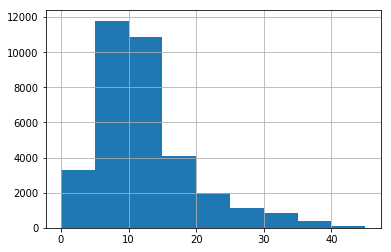

In [10]:
pd.Series([len(i) for i in tokenizer.texts_to_sequences(
    sample_data['tokens'].map(lambda x: ' '.join(x))
)]).hist(bins=range(0, 50, 5))

In [11]:
EMBEDDING_DIM = 300
MAXLEN = 15

In [12]:
sample_data['sequence'] = pad_sequences(
    tokenizer.texts_to_sequences(
        sample_data['tokens'].map(lambda x: ' '.join(x))
    ), maxlen=MAXLEN, padding='pre', truncating='post'
).tolist()

In [13]:
%%time
embeddings_index = get_embedding_index(
    pre_trained_file='/mnt/Datastore/WORK/pre-trained-models/glove.840B.300d.txt',
    word_index=tokenizer.word_index
)

CPU times: user 27.5 s, sys: 1.64 s, total: 29.1 s
Wall time: 30.2 s


In [14]:
%%time
# Keras reserves index 0 for masking
word_index = tokenizer.word_index

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.random.randn(len(word_index) + 1, EMBEDDING_DIM)
embedding_matrix[0] = np.zeros(EMBEDDING_DIM)

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 24946 word vectors.
CPU times: user 381 ms, sys: 32.1 ms, total: 413 ms
Wall time: 411 ms


In [16]:
sample_data['empty_sequence'] = sample_data.sequence.map(lambda x: sum(x) == 0)

In [19]:
sample_data = sample_data[~sample_data.empty_sequence]

In [20]:
sample_data.shape

(34507, 4)

## Image data processing

In [21]:
image_size = (150, 150, 3)

In [22]:
from keras.applications import VGG16, ResNet50
 
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=image_size)

# conv_base = ResNet50(
#     weights='imagenet',
#     pooling='max',
#     include_top=False,
#     input_shape=image_size
# )

In [23]:
def imread(name, flatten=False, mode=None, size=None):
    """
    Read an image from a file as an array.
    Parameters
    ----------
    name : str or file object
        The file name or file object to be read.
    flatten : bool, optional
        If True, flattens the color layers into a single gray-scale layer.
    mode : str, optional
        Mode to convert image to, e.g. ``'RGB'``.  See the Notes for more
        details.
    Returns
    -------
    imread : ndarray
        The array obtained by reading the image.
    Notes
    -----
    `imread` uses the Python Imaging Library (PIL) to read an image.
    The following notes are from the PIL documentation.
    `mode` can be one of the following strings:
    * 'L' (8-bit pixels, black and white)
    * 'P' (8-bit pixels, mapped to any other mode using a color palette)
    * 'RGB' (3x8-bit pixels, true color)
    * 'RGBA' (4x8-bit pixels, true color with transparency mask)
    * 'CMYK' (4x8-bit pixels, color separation)
    * 'YCbCr' (3x8-bit pixels, color video format)
    * 'I' (32-bit signed integer pixels)
    * 'F' (32-bit floating point pixels)
    PIL also provides limited support for a few special modes, including
    'LA' ('L' with alpha), 'RGBX' (true color with padding) and 'RGBa'
    (true color with premultiplied alpha).
    When translating a color image to black and white (mode 'L', 'I' or
    'F'), the library uses the ITU-R 601-2 luma transform::
        L = R * 299/1000 + G * 587/1000 + B * 114/1000
    When `flatten` is True, the image is converted using mode 'F'.
    When `mode` is not None and `flatten` is True, the image is first
    converted according to `mode`, and the result is then flattened using
    mode 'F'.
    """

    im = Image.open(name)
    
    if size is not None:
        im = im.resize(size)
        
    return fromimage(im, flatten=flatten, mode=mode)


def fromimage(im, flatten=False, mode=None):
    """
    Return a copy of a PIL image as a numpy array.
    Parameters
    ----------
    im : PIL image
        Input image.
    flatten : bool
        If true, convert the output to grey-scale.
    mode : str, optional
        Mode to convert image to, e.g. ``'RGB'``.  See the Notes of the
        `imread` docstring for more details.
    Returns
    -------
    fromimage : ndarray
        The different colour bands/channels are stored in the
        third dimension, such that a grey-image is MxN, an
        RGB-image MxNx3 and an RGBA-image MxNx4.
    """
    if not Image.isImageType(im):
        raise TypeError("Input is not a PIL image.")

    if mode is not None:
        if mode != im.mode:
            im = im.convert(mode)
    elif im.mode == 'P':
        # Mode 'P' means there is an indexed "palette".  If we leave the mode
        # as 'P', then when we do `a = array(im)` below, `a` will be a 2-D
        # containing the indices into the palette, and not a 3-D array
        # containing the RGB or RGBA values.
        if 'transparency' in im.info:
            im = im.convert('RGBA')
        else:
            im = im.convert('RGB')

    if flatten:
        im = im.convert('F')
    elif im.mode == '1':
        # Workaround for crash in PIL. When im is 1-bit, the call array(im)
        # can cause a seg. fault, or generate garbage. See
        # https://github.com/scipy/scipy/issues/2138 and
        # https://github.com/python-pillow/Pillow/issues/350.
        #
        # This converts im from a 1-bit image to an 8-bit image.
        im = im.convert('L')

    a = np.array(im)
    return a


def recast_array_to_image(float_array):
    uint_array = (float_array * 255 / np.max(float_array)).astype('uint8')

    return Image.fromarray(uint_array)


image_cache = {}

def load_image(path, size=image_size[:-1], transform_dim=True, as_float=True):
    if path not in image_cache:
        
        im = imread(path, size=size)
        
        if as_float:
            im = im.astype(np.float32)
            
        image_cache[path] = im
        
    return image_cache[path]

In [24]:
image_datagen = ImageDataGenerator(
    rescale=1./255,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True
)

sample_data['image_array'] = conv_base.predict(
    image_datagen.flow(
        np.stack(sample_data['image'].map(load_image)),
        batch_size=sample_data.shape[0], shuffle=False
    ).next()
).tolist()

In [72]:
def pretrain_model_image_generator(image_data, batch_size):
    image_datagen = ImageDataGenerator(
        rescale=1./255,
#         shear_range=0.1,
#         zoom_range=0.1,
#         horizontal_flip=True
    )

    # Exploit image_datagen for dynamic perturbation of the data    
    image_data = image_datagen.flow(
        image_data,
        batch_size=len(image_data), shuffle=False
    ).next()
    
    image_data = conv_base.predict(image_data)
    
    for i in range(0, len(image_data) // batch_size):
        yield image_data[i * batch_size: (i + 1) * batch_size]


def dataset_generator(dataset, batch_size=32, shuffle=True, negative_fold=1):
    index = np.array(dataset.index.values)  # Interestingly, data gets shuffled if we don't use np.array to create a new object!
    full_batch_size = batch_size * (negative_fold + 1)

    batch_index = []
    while True:
        
        if shuffle:
            np.random.shuffle(index)

        for i in index:
            if len(batch_index) < batch_size:
                batch_index.append(i)

            else:
                positive_df = dataset.loc[batch_index]
                
                batch_image_data = np.stack(positive_df['image_array'])
                positive_text_data = np.stack(positive_df['sequence'])
                
                if negative_fold:
                    batch_image_data = np.vstack([batch_image_data] * (negative_fold + 1))

                    negative_index = np.random.choice(index, size=batch_size * negative_fold, replace=True)
                    negative_text_data = np.stack(dataset.loc[negative_index]['sequence'])
                
                    text_data = np.vstack([positive_text_data, negative_text_data])
                else:
                    text_data = positive_text_data
                
                label = np.zeros(full_batch_size)
                label[:batch_size] = 1
                
                ix = np.array(range(full_batch_size))
                if shuffle:
                    ix = np.random.choice(ix, size=full_batch_size, replace=False)
                
                batch_index = []
                yield [text_data[ix], batch_image_data[ix]], label[ix]
#                 yield [text_data[ix], conv_base.predict(batch_image_data[ix])], label[ix]

In [73]:
sample_data.head()

,image,tokens,sequence,empty_sequence,image_array
0,../../data/img_common_animals/amphibians/tOSgy...,"[amphibian, wikipedia, collage, of, amphibians]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 266, 114, 6466,...",False,"[[[2.54179167747, 0.0, 0.338102996349, 0.08324..."
1,../../data/img_common_animals/amphibians/BA01z...,"[amphibians, san, diego, zoo, animals, plants,...","[0, 0, 0, 0, 0, 0, 0, 0, 69, 300, 431, 35, 47,...",False,"[[[0.293235242367, 0.0, 0.0, 0.473555594683, 0..."
2,../../data/img_common_animals/amphibians/TKxsc...,"[amphibians, hero.jpg, ]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 69, 7510]",False,"[[[0.0, 0.0, 0.0, 0.0, 0.0670817047358, 0.0, 0..."
3,../../data/img_common_animals/amphibians/mgGpN...,"[amphibians, 2018, news, and, scientific, arti...","[69, 337, 86, 4, 759, 1150, 10, 210, 161, 127,...",False,"[[[0.0, 0.0, 0.304386913776, 0.0, 0.2095115482..."
4,../../data/img_common_animals/amphibians/a4k5F...,"[reticulated, glass, frog, eggs.ngsversion.146...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8979, 157...",False,"[[[0.672541499138, 0.0, 0.0, 0.0155107825994, ..."


In [91]:
data_gen = dataset_generator(sample_data, batch_size=32, shuffle=True, negative_fold=1)

In [92]:
%%time
q = data_gen.next()

CPU times: user 8.55 ms, sys: 30 µs, total: 8.58 ms
Wall time: 7.93 ms


In [93]:
from keras.layers import Input, GRU, Bidirectional, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, LeakyReLU

In [94]:
# text_model_input = keras.layers.Input(shape=(MAXLEN,))
# text_embedding = keras.layers.Embedding(
#     input_dim=len(word_index) + 1, output_dim=EMBEDDING_DIM,
#     weights=[embedding_matrix],
#     trainable=True
# )(text_model_input)

# text_gru = GRU(64, return_sequences=True)(text_embedding)
# text_gru = GRU(64, return_sequences=False)(text_gru)
# text_dense = Dense(128, activation='relu')(text_gru)
# text_dense = Dropout(0.3)(text_dense)
# text_dense = Dense(128, activation='relu')(text_dense)
# text_dense = Dropout(0.3)(text_dense)
# text_model_output = Dense(100, activation='tanh')(text_dense)
# # text_model_output = LeakyReLU(alpha=0.2)(text_model_output)

# image_model_input = Input(shape=(8, 8, 512))
# image_conv = Conv2D(64, 2)(image_model_input)
# image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)
# # image_conv = Conv2D(64, 2)(image_pool)
# # image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)
# image_flatten = Flatten()(image_pool)
# image_dense = Dense(128, activation='relu')(image_flatten)
# image_dense = Dropout(0.3)(image_dense)
# image_model_output = Dense(100, activation='tanh')(image_dense)
# # image_model_output = LeakyReLU(alpha=0.2)(image_model_output)


# target_ouput = keras.layers.merge([text_model_output, image_model_output], mode='cos')
# target_ouput = keras.layers.Reshape((1,), input_shape=(1, 1))(target_ouput)

# ImageSearchModel = keras.models.Model(inputs=[text_model_input, image_model_input], outputs=[target_ouput])

# ImageSearchModel.compile(
#     optimizer='adam',
#     loss='binary_crossentropy'
# )

In [95]:
# text_model_input = keras.layers.Input(shape=(MAXLEN,))
# text_embedding = keras.layers.Embedding(
#     input_dim=len(word_index) + 1, output_dim=EMBEDDING_DIM,
#     weights=[embedding_matrix],
#     trainable=True
# )(text_model_input)

# text_gru = GRU(128, return_sequences=True)(text_embedding)
# text_gru = GRU(64)(text_gru)
# text_dense = Dense(300, activation='relu')(text_gru)
# text_dense = Dropout(0.3)(text_dense)
# # text_dense = keras.layers.Reshape((300 * 30,), input_shape=(30, 300))(text_dense)
# text_dense = Dense(256, activation='relu')(text_dense)
# text_dense = Dropout(0.5)(text_dense)
# text_model_output = Dense(100)(text_dense)
# text_model_output = LeakyReLU(alpha=0.2)(text_model_output)

# image_model_input = Input(shape=(2048,))
# # image_model_shaped = keras.layers.Reshape((64, 64, 2), input_shape=(4, 4, 512))(image_model_input)

# # image_conv = Conv2D(128, 2)(image_model_input)
# # image_conv = Conv2D(64, 2)(image_conv)
# # image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)

# # image_conv = Conv2D(32, 2)(image_pool)

# # image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)
# # image_flatten = Flatten()(image_pool)
# image_dense = Dense(300, activation='relu')(image_model_input)
# image_dense = Dropout(0.3)(image_dense)
# image_model_output = Dense(100)(image_dense)
# image_model_output = LeakyReLU(alpha=0.2)(image_model_output)


# target_ouput = keras.layers.merge([text_model_output, image_model_output], mode='cos')
# target_ouput = keras.layers.Reshape((1,), input_shape=(1, 1))(target_ouput)

# ImageSearchModel = keras.models.Model(inputs=[text_model_input, image_model_input], outputs=[target_ouput])

# ImageSearchModel.compile(
#     optimizer='adam',
#     loss='binary_crossentropy'
# )

In [255]:
text_model_input = keras.layers.Input(shape=(MAXLEN,))
text_embedding = keras.layers.Embedding(
    input_dim=len(word_index) + 1, output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    trainable=False
)(text_model_input)

text_gru = Bidirectional(GRU(64, return_sequences=False))(text_embedding)
# text_gru = Bidirectional(GRU(64))(text_gru)
text_dense = Dense(300, activation='relu')(text_gru)
text_dense = Dropout(0.2)(text_dense)
text_model_output = Dense(200, activation='tanh')(text_dense)

# text_gru = GRU(64, return_sequences=True)(text_embedding)
# text_gru = GRU(64, return_sequences=False)(text_gru)
# text_dense = Dense(128, activation='relu')(text_gru)
# text_dense = Dropout(0.3)(text_dense)
# text_dense = Dense(128, activation='relu')(text_dense)
# text_dense = Dropout(0.3)(text_dense)
# text_model_output = Dense(100, activation='tanh')(text_dense)
# # text_model_output = LeakyReLU(alpha=0.2)(text_model_output)


image_model_input = Input(shape=(4, 4, 512))
# image_model_shaped = keras.layers.Reshape((64, 64, 2), input_shape=(4, 4, 512))(image_model_input)

image_conv = Conv2D(64, 2)(image_model_input)
# image_conv = Conv2D(64, 2)(image_conv)
image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)

# image_conv = Conv2D(32, 2)(image_pool)

# image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)
image_flatten = Flatten()(image_pool)
image_dense = Dense(300, activation='relu')(image_flatten)
image_dense = Dropout(0.3)(image_dense)
image_model_output = Dense(200, activation='tanh')(image_flatten)

target_ouput = keras.layers.merge([text_model_output, image_model_output], mode='cos')
target_ouput = keras.layers.Reshape((1,), input_shape=(1, 1))(target_ouput)

ImageSearchModel = keras.models.Model(inputs=[text_model_input, image_model_input], outputs=[target_ouput])

ImageSearchModel.compile(
    optimizer='adam',
    loss='binary_crossentropy'
)

In [256]:
ImageModel = keras.models.Model(inputs=[image_model_input], outputs=[image_model_output])
TextModel = keras.models.Model(inputs=[text_model_input], outputs=[text_model_output])

In [257]:
ImageSearchModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 15)           0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 15, 300)      10329900    input_24[0][0]                   
__________________________________________________________________________________________________
input_25 (InputLayer)           (None, 4, 4, 512)    0                                            
__________________________________________________________________________________________________
bidirectional_16 (Bidirectional (None, 128)          140160      embedding_12[0][0]               
__________________________________________________________________________________________________
conv2d_15 

In [258]:
full_data_df.shape

(34889, 6)

In [259]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=1)

Epoch 1/1
1090/1090 [==============================] - 26s 24ms/step - loss: 0.6352
CPU times: user 45.1 s, sys: 1.19 s, total: 46.3 s
Wall time: 27.2 s


In [260]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=10)

Epoch 1/10
1090/1090 [==============================] - 24s 22ms/step - loss: 0.5386
Epoch 2/10
1090/1090 [==============================] - 24s 22ms/step - loss: 0.5192
Epoch 3/10
1090/1090 [==============================] - 24s 22ms/step - loss: 0.4824
Epoch 4/10
1090/1090 [==============================] - 24s 22ms/step - loss: 0.4695
Epoch 5/10
1090/1090 [==============================] - 24s 22ms/step - loss: 0.4458
Epoch 6/10
1090/1090 [==============================] - 24s 22ms/step - loss: 0.4666
Epoch 7/10
1090/1090 [==============================] - 24s 22ms/step - loss: 0.4267
Epoch 8/10
1090/1090 [==============================] - 24s 22ms/step - loss: 0.4141
Epoch 9/10
1090/1090 [==============================] - 24s 22ms/step - loss: 0.3967
Epoch 10/10
1090/1090 [==============================] - 24s 22ms/step - loss: 0.4114
CPU times: user 6min 59s, sys: 12.3 s, total: 7min 11s
Wall time: 4min


In [261]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=300)

Epoch 1/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.4074
Epoch 2/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.3867
Epoch 3/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.4168
Epoch 4/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.3744
Epoch 5/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.3873
Epoch 6/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.3549
Epoch 7/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.3453
Epoch 8/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.3431
Epoch 9/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.3285
Epoch 10/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.3402
Epoch 11/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.3188
Epoch 12/300
1090/1090 [============================

1090/1090 [==============================] - 24s 22ms/step - loss: 0.1789
Epoch 187/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1802
Epoch 188/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1789
Epoch 189/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1799
Epoch 190/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1774
Epoch 191/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1744
Epoch 192/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2406
Epoch 193/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1852
Epoch 194/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1761
Epoch 195/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1746
Epoch 196/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1741
Epoch 197/300
1090/1090 [=====================

In [110]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=300)

Epoch 1/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.4902
Epoch 3/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.4662
Epoch 4/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.4296
Epoch 5/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.4116
Epoch 6/300
1090/1090 [==============================] - 23s 21ms/step - loss: 0.3972
Epoch 7/300
1090/1090 [==============================] - 23s 22ms/step - loss: 0.3884
Epoch 8/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.3842
Epoch 9/300
1090/1090 [==============================] - 23s 21ms/step - loss: 0.4648
Epoch 10/300
 423/1090 [==========>...................] - ETA: 14s - loss: 0.4412

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1090/1090 [==============================] - 23s 21ms/step - loss: 0.3150
Epoch 26/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.3065
Epoch 27/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.3120
Epoch 28/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2996
Epoch 29/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.3489
Epoch 30/300
1090/1090 [==============================] - 23s 21ms/step - loss: 0.4170
Epoch 31/300
1090/1090 [==============================] - 23s 22ms/step - loss: 0.3472
Epoch 32/300
1090/1090 [==============================] - 23s 21ms/step - loss: 0.3234
Epoch 33/300
 728/1090 [===================>..........] - ETA: 7s - loss: 0.3193

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1090/1090 [==============================] - 24s 22ms/step - loss: 0.2602
Epoch 50/300
1090/1090 [==============================] - 23s 21ms/step - loss: 0.3339
Epoch 51/300
1090/1090 [==============================] - 23s 21ms/step - loss: 0.2759
Epoch 52/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2476
Epoch 53/300
1090/1090 [==============================] - 23s 21ms/step - loss: 0.2475
Epoch 54/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2446
Epoch 55/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2431
Epoch 56/300
1090/1090 [==============================] - 23s 21ms/step - loss: 0.2407
Epoch 57/300
 977/1090 [=========================>....] - ETA: 2s - loss: 0.2435

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1090/1090 [==============================] - 24s 22ms/step - loss: 0.2467
Epoch 75/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2245
Epoch 76/300
1090/1090 [==============================] - 23s 22ms/step - loss: 0.2189
Epoch 77/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2188
Epoch 78/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.3356
Epoch 79/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2593
Epoch 80/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2341
Epoch 81/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2218
Epoch 82/300
 235/1090 [=====>........................] - ETA: 18s - loss: 0.2227

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1090/1090 [==============================] - 24s 22ms/step - loss: 0.2097
Epoch 100/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2089
Epoch 101/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2091 0s - loss: 0.209
Epoch 102/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2098
Epoch 103/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2077
Epoch 104/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2080
Epoch 105/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2076
Epoch 106/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2049 0s
Epoch 107/300
 292/1090 [=======>......................] - ETA: 17s - loss: 0.2108

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1090/1090 [==============================] - 24s 22ms/step - loss: 0.1969
Epoch 124/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2012
Epoch 125/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2037
Epoch 126/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1998
Epoch 127/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1973
Epoch 128/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2021
Epoch 129/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1979
Epoch 130/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1954
Epoch 131/300
 646/1090 [================>.............] - ETA: 9s - loss: 0.1902

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1090/1090 [==============================] - 24s 22ms/step - loss: 0.1913
Epoch 148/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1923
Epoch 149/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1951
Epoch 150/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1936
Epoch 151/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1913
Epoch 152/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1922
Epoch 153/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1913
Epoch 154/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.2420
Epoch 155/300
 202/1090 [====>.........................] - ETA: 19s - loss: 0.2037

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1090/1090 [==============================] - 24s 22ms/step - loss: 0.1902
Epoch 172/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1876
Epoch 173/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1881
Epoch 174/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1870
Epoch 175/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1911
Epoch 176/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1918
Epoch 177/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1903
Epoch 178/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1860
Epoch 179/300
 180/1090 [===>..........................] - ETA: 19s - loss: 0.1873

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1090/1090 [==============================] - 23s 22ms/step - loss: 0.1878
Epoch 196/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1858
Epoch 197/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1843
Epoch 198/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1833
Epoch 257/300
1090/1090 [==============================] - 23s 22ms/step - loss: 0.1841
Epoch 258/300
1090/1090 [==============================] - 23s 21ms/step - loss: 0.1828
Epoch 259/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1846
Epoch 260/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1820
Epoch 261/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1812
Epoch 262/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1810
Epoch 263/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1808
Epoch 264/300
 958/1090 [=====================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1090/1090 [==============================] - 24s 22ms/step - loss: 0.1782
Epoch 277/300
1090/1090 [==============================] - 23s 21ms/step - loss: 0.1800
Epoch 278/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1820
Epoch 279/300
1090/1090 [==============================] - 23s 22ms/step - loss: 0.1771
Epoch 280/300
1090/1090 [==============================] - 23s 22ms/step - loss: 0.1805
Epoch 281/300
1090/1090 [==============================] - 23s 22ms/step - loss: 0.1844
Epoch 282/300
1090/1090 [==============================] - 23s 21ms/step - loss: 0.1817 0s - loss: 0.1
Epoch 283/300
1090/1090 [==============================] - 23s 22ms/step - loss: 0.1794
Epoch 284/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1794
Epoch 285/300
1090/1090 [==============================] - 23s 22ms/step - loss: 0.1783
Epoch 286/300
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1835
Epoch 287/300
1090/1090 [======

In [174]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=100)

Epoch 1/100
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1804
Epoch 2/100
1090/1090 [==============================] - 23s 21ms/step - loss: 0.2166
Epoch 3/100
1090/1090 [==============================] - 23s 21ms/step - loss: 0.1776
Epoch 4/100
1090/1090 [==============================] - 23s 21ms/step - loss: 0.1778
Epoch 5/100
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1763
Epoch 6/100
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1746
Epoch 7/100
1090/1090 [==============================] - 23s 21ms/step - loss: 0.1772
Epoch 8/100
1090/1090 [==============================] - 23s 22ms/step - loss: 0.1760
Epoch 9/100
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1757
Epoch 10/100
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1790
Epoch 11/100
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1820
Epoch 12/100
1090/1090 [============================

In [175]:
# %%time
# predict_image_datagen = ImageDataGenerator(
#     rescale=1./255,
# )

# image_data = sample_data['image'].map(load_image)
# image_data = np.stack(image_data)

# # Exploit image_datagen for dynamic perturbation of the data
# image_data = predict_image_datagen.flow(
#     image_data,
#     batch_size=sample_data.shape[0], shuffle=False
# ).next()

# image_embeddings = ImageModel.predict(conv_base.predict(image_data))

In [176]:
sample_data.columns

Index([u'image', u'tokens', u'sequence', u'empty_sequence', u'image_array'], dtype='object')

In [262]:
%%time
image_embeddings = ImageModel.predict(np.stack(sample_data['image_array'].values))

CPU times: user 6.87 s, sys: 689 ms, total: 7.56 s
Wall time: 7.4 s


In [263]:
image_embeddings.shape

(34507, 200)

In [264]:
from sklearn.metrics.pairwise import cosine_similarity

In [276]:
seq = pad_sequences(
    tokenizer.texts_to_sequences(
        [' '.join(process_raw_text('dogs playing'))]
    ), maxlen=MAXLEN, padding='pre', truncating='post'
)
query_vector = TextModel.predict(
    seq
)

seq

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  194, 1047]], dtype=int32)

In [277]:
%%time
res = cosine_similarity(image_embeddings, query_vector)

CPU times: user 32.1 ms, sys: 41.5 ms, total: 73.6 ms
Wall time: 21.2 ms


In [278]:
top_ix = res[:, 0].argsort()[::-1][:10]
print(res[:, 0][top_ix])
print(top_ix)

[0.9999952  0.99998176 0.99994457 0.99988395 0.99988365 0.9998743
 0.99987274 0.99985385 0.99984556 0.99984545]
[1269 1236  934 1203  944  900  961 1147  910  698]


In [279]:
sample_data.iloc[top_ix]

,image,tokens,sequence,empty_sequence,image_array
1277,../../data/img_common_animals/dog/Q5ZlTX2iNPFu...,"[how, to, give, your, dog, a, bath, petfinder]","[0, 0, 0, 0, 0, 0, 0, 30, 6, 1074, 73, 53, 3, ...",False,"[[[1.08149683475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1244,../../data/img_common_animals/dog/76Hktb3RU9Lk...,"[golden, retriever, dog, 10.000, free, article...","[0, 0, 0, 0, 0, 0, 0, 0, 638, 2745, 53, 36, 11...",False,"[[[0.0, 0.0, 0.717231214046, 0.215729102492, 0..."
938,../../data/img_common_animals/dog/CiSFWARlxLhO...,"[the, association, of, professional, dog, trai...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 477, 2, 2490...",False,"[[[0.101257860661, 0.0, 0.0, 0.0, 0.0992488712..."
1211,../../data/img_common_animals/dog/eeOMkAliSOK1...,"[why, dogs, eat, grass, and, how, to, prevent,...","[135, 194, 334, 465, 4, 30, 6, 1885, 82, 4746,...",False,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.070739..."
948,../../data/img_common_animals/dog/plWUQVEPrg_M...,"[adoptable, dogs, dog, tales, rescue, and, san...","[0, 0, 0, 0, 0, 0, 0, 0, 5184, 194, 53, 3341, ...",False,"[[[0.676771044731, 0.0, 0.0, 0.0, 0.5528129339..."
904,../../data/img_common_animals/dog/NO6MvkBx4L8Z...,"[dog, training, puppy, and, adult, dog, traini...","[0, 0, 0, 0, 53, 1102, 716, 4, 384, 53, 1102, ...",False,"[[[0.0, 0.0, 0.0, 0.0, 0.00638453662395, 0.0, ..."
965,../../data/img_common_animals/dog/l0MVo8tGTosG...,"[top, 10, dog, breeds, most, popular, dog, bre...","[171, 119, 53, 244, 134, 617, 53, 244, 5, 1, 4...",False,"[[[0.0, 0.0, 0.571881711483, 0.0, 0.0, 0.0, 0...."
1151,../../data/img_common_animals/dog/Lf4mDAmrKaAq...,"[lab, grown, pet, food, promises, a, wholesome...","[0, 666, 2094, 126, 224, 9154, 3, 5217, 2612, ...",False,"[[[0.160158753395, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
914,../../data/img_common_animals/dog/IFMSUe4x4uw_...,"[study, proves, that, your, dog, really, is, d...","[402, 4377, 49, 73, 53, 546, 13, 34, 325, 13, ...",False,"[[[0.0, 0.0, 0.902540743351, 0.138717100024, 0..."
702,../../data/img_common_animals/dog/71jMekyOJL5K...,"[dog, insurance, puppy, insurance, healthy, pa...","[0, 0, 0, 0, 0, 0, 0, 53, 1554, 716, 1554, 997...",False,"[[[0.308931589127, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."


In [280]:
import pylab as plt

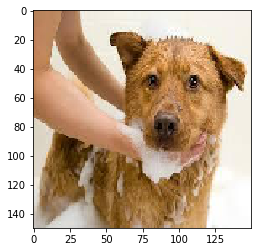

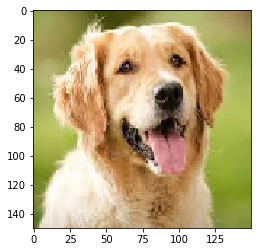

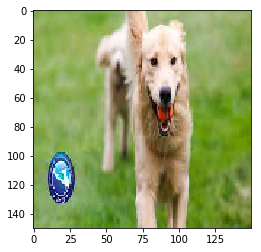

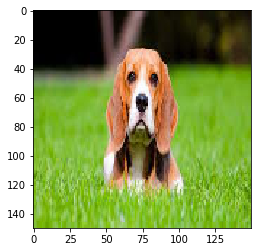

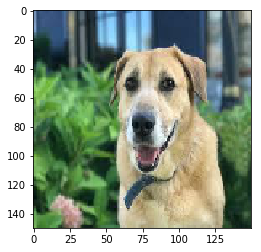

In [281]:
# %%time
for iloc in top_ix[:5]:
    im = Image.fromarray(
        load_image(
            sample_data.iloc[iloc]['image'],
            size=None, transform_dim=False
    #         '../../data/img/physics/jT6AxO5im1R5zM:.jpeg'
        ).astype(np.uint8)
    )
    plt.figure()
    plt.imshow(np.asarray(im))
    
    
# im.show

# Query by image

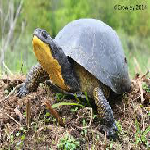

In [271]:
iloc = 6394
im = Image.fromarray(
    load_image(
        sample_data.iloc[iloc]['image'],
        size=None, transform_dim=False
#         '../../data/img/physics/jT6AxO5im1R5zM:.jpeg'
    ).astype(np.uint8)
)
im
# plt.figure()
# plt.imshow(np.asarray(im))

In [272]:
image_query = ImageModel.predict(np.stack(sample_data.iloc[[iloc]].image_array.values))
res_im = cosine_similarity(image_embeddings, image_query)

In [273]:
top_im_ix = res_im[:, 0].argsort()[::-1][:10]
print(res_im[:, 0][top_im_ix])
print(top_im_ix)

[0.99999976 0.9999378  0.999929   0.99958324 0.9990483  0.99416715
 0.99400795 0.99340594 0.99269813 0.99253714]
[ 6394 12313 26404 14125 14639 26786  8642 14162 14535 14598]


In [274]:
sample_data.iloc[top_im_ix]

,image,tokens,sequence,empty_sequence,image_array
6489,../../data/img_common_animals/reptile/picgqWaC...,"[canadian, herpetological, society, chs, ident...","[302, 4537, 303, 4709, 1026, 266, 4, 100, 1477...",False,"[[[0.192258030176, 0.0, 0.0, 0.0, 0.4644415378..."
12505,../../data/img_common_animals/frog/77UP8a9v-sW...,"[pacific, chorus, frog, natural, history, ]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 916, 7543, 76, ...",False,"[[[0.911019206047, 0.0, 0.0, 0.0, 0.0185992270..."
26685,../../data/img_common_animals/worm/6gQruU7C07J...,"[worm, grows, 2, heads, in, space, surprising,...","[0, 0, 0, 0, 0, 0, 0, 85, 2858, 185, 1492, 5, ...",False,"[[[0.744729816914, 0.0, 0.0, 0.0, 0.1082994192..."
14317,../../data/img_common_animals/turtle/SAvJzNBy-...,"[sea, turtle, rehabilitation, ]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 103, 83, ...",False,"[[[0.187583550811, 0.0, 0.0, 0.0, 0.1515887230..."
14831,../../data/img_common_animals/turtle/gQWGR0nAk...,"[upload.wikimedia.org, wikipedia, commons, thu...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 6187, 114, 524, 24...",False,"[[[0.442771077156, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
27069,../../data/img_common_animals/worm/vI3_Y_TNn84...,"[castings, worm, castings, what, are, they, ?,...","[0, 0, 0, 1443, 85, 1443, 80, 20, 125, 18, 30,...",False,"[[[0.848864912987, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
8802,../../data/img_common_animals/lion/Tow9PYO2-oY...,"[seal, sea, lion, and, walrus, what, 's, the, ...","[0, 0, 3765, 103, 33, 4, 80, 9, 1, 366, 18, 5,...",False,"[[[0.176561176777, 0.0, 0.0, 0.0, 0.0117200165..."
14354,../../data/img_common_animals/turtle/c0qB3qOPc...,"[turtle, cut, free, from, 6, pack, rings, is, ...","[0, 83, 2566, 36, 31, 373, 882, 5587, 13, 492,...",False,"[[[0.594010472298, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
14727,../../data/img_common_animals/turtle/RbO9Jb6uT...,"[sea, turtle, wikipedia, ]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 103, 83, ...",False,"[[[0.44530916214, 0.0, 0.0, 0.0708426088095, 0..."
14790,../../data/img_common_animals/turtle/_ovqU8BKU...,"[man, tries, to, smuggle, turtle, disguised, a...","[0, 0, 0, 0, 0, 0, 0, 282, 2659, 6, 83, 66, 39...",False,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


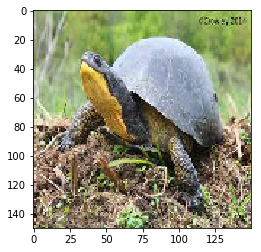

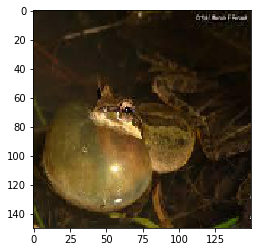

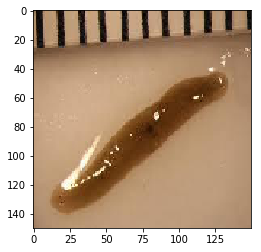

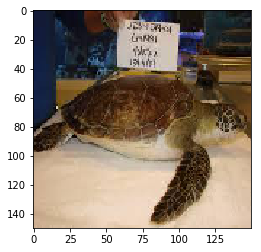

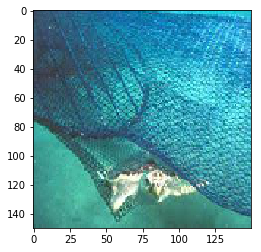

In [275]:
# %%time
for iloc in top_im_ix[:5]:
    im = Image.fromarray(
        load_image(
            sample_data.iloc[iloc]['image'],
            size=None, transform_dim=False
    #         '../../data/img/physics/jT6AxO5im1R5zM:.jpeg'
        ).astype(np.uint8)
    )
    plt.figure()
    plt.imshow(np.asarray(im))
    
    
# im.show

In [156]:
np.array([sample_data.loc[700].image_array]).shape #values.asarray()

(1, 4, 4, 512)

In [162]:
np.stack(sample_data.loc[[700]].image_array.values).shape

(1, 4, 4, 512)

In [348]:
im = imread('../../data/img/phone/UxhcE10enW7OeM:.png')

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ T

In [306]:
sample_data.iloc[9898]

image                   ../../data/img/phone/UxhcE10enW7OeM:.png
tokens         [cell, cellphone, phone, free, vector, graphic...
sequence       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
image_array    [[[0.0591950416565, 0.0, 0.0, 0.0191860049963,...
Name: 1761, dtype: object

In [308]:
full_data_df.iloc[9898]['image_link']

u'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcREnp_9QOWYxK5irRyhYpGztZtrnBgRDTitn7CsuNdLyEID0SJz'

In [42]:
record = sample_data.loc[3]

In [43]:
print record['caption'].lower()
print record['title'].lower()

caring for cats in cold weather - grey and white cat close up
caring for cats in cold weather - argos pet insurance


In [ ]:
EmbeddingModel = keras.models.Model(inputs=[text_model_input], outputs=[text_model_input])